<a href="https://colab.research.google.com/github/dzikraridha/movie-poster-emotion/blob/main/model_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', timeout_ms=300000) # Increased timeout to 5 minutes

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/MovieGenreEmotion_clean.csv", encoding='ISO-8859-1')
df.head()

,imdbId,Genre,Title,Image_Paths,emotion
0,114709,Animation|Adventure|Comedy,Toy Story (1995),/content/drive/MyDrive/Posters/114709.jpg,"['Happy', 'Surprised', 'Sad']"
1,113497,Action|Adventure|Family,Jumanji (1995),/content/drive/MyDrive/Posters/113497.jpg,"['Fear', 'Sad', 'Angry', 'Neutral', 'Happy', '..."
2,114885,Comedy|Drama|Romance,Waiting to Exhale (1995),/content/drive/MyDrive/Posters/114885.jpg,"['Happy', 'Angry', 'Surprised', 'Sad']"
3,113041,Comedy|Family|Romance,Father of the Bride Part II (1995),/content/drive/MyDrive/Posters/113041.jpg,"['Happy', 'Neutral', 'Surprised', 'Sad']"
4,113277,Action|Crime|Drama,Heat (1995),/content/drive/MyDrive/Posters/113277.jpg,"['Fear', 'Sad', 'Disgust', 'Angry', 'Surprised']"


In [ ]:
pip install tensorflow keras pandas numpy matplotlib

In [ ]:
!pip install --upgrade tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.4/615.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 35.8 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [ ]:
# Path to the folder where images are stored
image_folder = '/content/drive/MyDrive/Posters'

# Get the list of all image files in the folder
image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.endswith('.jpg')]

# Display the first few image paths
print(image_paths[:5])

['/content/drive/MyDrive/Posters/197154.jpg', '/content/drive/MyDrive/Posters/55995.jpg', '/content/drive/MyDrive/Posters/1975179.jpg', '/content/drive/MyDrive/Posters/1942798.jpg', '/content/drive/MyDrive/Posters/4063438.jpg']


In [ ]:
# Create list of all emotions
emotions = ['Fear', 'Disgust', 'Surprised', 'Neutral', 'Happy', 'Sad', 'Angry']

In [ ]:
emotion_to_index = {emotion: idx for idx, emotion in enumerate(emotions)}

In [ ]:
df_sampled = df.sample(n=6800, random_state=42)

In [ ]:
genres_to_emotion = {
    'Action': ['Surprised', 'Fear', 'Angry'],
    'Adventure': ['Surprised', 'Happy'],
    'Animation': ['Happy', 'Surprised', 'Sad'],
    'Biography': ['Sad', 'Angry', 'Neutral'],
    'Comedy': ['Happy', 'Surprised'],
    'Crime': ['Angry', 'Fear', 'Disgust'],
    'Documentary': ['Neutral','Angry', 'Disgust'],
    'Drama': ['Sad', 'Angry'],
    'Family': ['Happy', 'Sad', 'Neutral'],
    'Fantasy': ['Surprised', 'Happy', 'Fear'],
    'History': ['Sad', 'Angry'],
    'Horror': ['Fear', 'Disgust'],
    'Music': ['Happy', 'Neutral'],
    'Mystery': ['Surprised', 'Fear'],
    'Romance': ['Happy', 'Sad'],
    'Sci-Fi': ['Surprised', 'Fear', 'Disgust'],
    'Sport': ['Happy', 'Surprised'],
    'Thriller': ['Fear', 'Surprised'],
    'War': ['Sad', 'Angry']
}

In [ ]:
# Converts movie genres into a multi-hot encoded emotion vector.
def genres_to_emotions(genres):
    genres_list = genres.split('|') if pd.notnull(genres) else []
    emotion_vector = [0] * len(emotions)

    for genre in genres_list:
        # Skip invalid or empty genres
        if genre in genres_to_emotion:
            for emotion in genres_to_emotion[genre]:
                emotion_index = emotions.index(emotion)
                emotion_vector[emotion_index] = 1

    return emotion_vector

# Preprocessing Step
valid_genres = set(genres_to_emotion.keys())

def filter_valid_genres(row):
    genres = row['Genre'].split('|') if pd.notnull(row['Genre']) else []
    return all(genre in valid_genres for genre in genres)

df_sampled = df_sampled[df_sampled.apply(filter_valid_genres, axis=1)]
df_sampled['emotion'] = df_sampled['Genre'].apply(genres_to_emotions)

In [ ]:
#Checks if the 'emotion' column in a DataFrame is multi-hot encoded based on the 'genres_to_emotion' mapping.

def is_emotion_multi_hot_encoded(df):

    # Check if the 'emotion' column exists and contains lists
    if 'emotion' in df.columns and all(isinstance(item, list) for item in df['emotion']):
        # Check if any movie has multiple emotions (more than one '1' in the list)
        has_multiple_emotions = any(sum(item) > 1 for item in df['emotion'])
        return has_multiple_emotions
    else:
        return False

# Check if 'emotion' column is multi-hot encoded
if is_emotion_multi_hot_encoded(df_sampled):
    print("The 'emotion' column is likely multi-hot encoded.")
else:
    print("The 'emotion' column is not multi-hot encoded.")

The 'emotion' column is likely multi-hot encoded.


In [ ]:
print(df_sampled[['Genre', 'emotion']].head())


                   Genre                emotion
28892              Drama  [0, 0, 0, 0, 0, 1, 1]
3776   Adventure|Fantasy  [1, 0, 1, 0, 1, 0, 0]
23339             Sci-Fi  [1, 1, 1, 0, 0, 0, 0]
7266              Comedy  [0, 0, 1, 0, 1, 0, 0]
13416      Drama|Fantasy  [1, 0, 1, 0, 1, 1, 1]


In [ ]:
class_weights = {}
for i, emotion in enumerate(emotions):
    # Accessing the i-th emotion using a list comprehension
    emotion_values = [row[i] for row in df_sampled['emotion'].to_list()]
    class_weights[i] = class_weight.compute_class_weight(
        'balanced',
        classes=np.unique(emotion_values),
        y=emotion_values
    )

In [ ]:
all_emotions = np.concatenate(df_sampled['emotion'].to_list())
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(all_emotions),  # Use all unique emotion values (0 and 1)
    y=all_emotions  # Use all emotion occurrences
)

In [ ]:
assert df_sampled['emotion'].apply(lambda x: sum(x) > 0).all(), "Some movies have no emotions assigned!"

In [ ]:
# Sample test input
sample_genres = "Animation|Adventure|Comedy"

# Get the multi-hot encoded emotion vector
multi_hot_vector = genres_to_emotions(sample_genres)

# Print the results
print(f"Genres: {sample_genres}")
print(f"Multi-hot encoded emotions: {multi_hot_vector}")
print(f"Emotions: {emotions}")  # To map the indices to actual emotions

Genres: Animation|Adventure|Comedy
Multi-hot encoded emotions: [0, 0, 1, 0, 1, 1, 0]
Emotions: ['Fear', 'Disgust', 'Surprised', 'Neutral', 'Happy', 'Sad', 'Angry']


In [ ]:
batch_size = 32
img_size = (224, 224)

In [ ]:
# Flatten the emotion lists to get all emotion occurrences
all_emotions = np.concatenate(df_sampled['emotion'].to_list())

# Calculate class weights for each emotion
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(all_emotions),  # Use all unique emotion values (0 and 1)
    y=all_emotions  # Use all emotion occurrences
)

# Create a dictionary mapping emotion index to class weight
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
# Assume class_weights has weights for 0 and 1, representing absence and presence of emotions

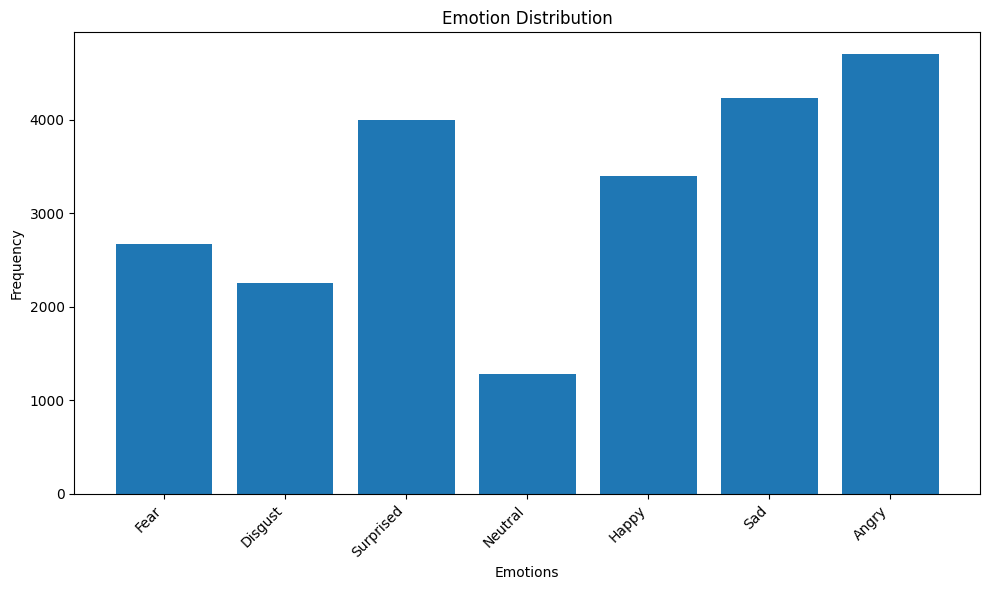

In [ ]:
def plot_emotion_distribution(df, genres_to_emotion, emotions):
    emotion_counts = {emotion: 0 for emotion in emotions}

    # Iterate through movie rows to collect emotion counts
    for _, row in df.iterrows():
        emotions_for_movie = genres_to_emotions(row['Genre'])  # Get emotions for the movie
        if emotions_for_movie is not None:  # Skip movies with unmapped genres
            for i, emotion_present in enumerate(emotions_for_movie):
                if emotion_present:  # Increment count if emotion is present (1)
                    emotion_counts[emotions[i]] += 1

    plt.figure(figsize=(10, 6))  # Set figure size for better readability
    plt.bar(emotion_counts.keys(), emotion_counts.values())
    plt.title("Emotion Distribution")
    plt.xlabel("Emotions")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for clarity
    plt.tight_layout()  # Adjust layout to prevent labels from overlapping
    plt.show()

plot_emotion_distribution(df_sampled, genres_to_emotions, emotions)

In [ ]:
class ImageDataGeneratorWithEmotions(Sequence):
    def __init__(self, image_folder, df_sampled, batch_size, img_size, emotions, shuffle=True, augment=False, **kwargs):
        super().__init__(**kwargs)

        self.image_folder = image_folder
        self.df_sampled = df_sampled
        self.batch_size = batch_size
        self.img_size = img_size
        self.emotions = emotions
        self.shuffle = shuffle
        self.augment = augment
        self.indexes = np.arange(len(self.df_sampled))

        # Initialize augmentation generator
        self.datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        ) if self.augment else None

        # Initialize index array
        self.indexes = np.arange(len(self.df_sampled))
        self.on_epoch_end()

    def __len__(self):
        # Number of batches per epoch
        return int(np.ceil(len(self.df_sampled) / self.batch_size))

    def __getitem__(self, index):
        # Get batch indexes
        start_index = index * self.batch_size
        end_index = min((index + 1) * self.batch_size, len(self.df_sampled))
        batch_indexes = self.indexes[start_index:end_index]

        # Get batch data
        batch_filenames = self.df_sampled.iloc[batch_indexes]['imdbId'].values
        batch_genres = self.df_sampled.iloc[batch_indexes]['Genre'].values

        # Initialize arrays
        batch_size_actual = len(batch_filenames)
        images = np.zeros((batch_size_actual, *self.img_size, 3), dtype=np.float32)
        emotion_labels = np.zeros((batch_size_actual, len(self.emotions)), dtype=np.float32)

        # Load and preprocess each image
        for i, (imdbId, genres) in enumerate(zip(batch_filenames, batch_genres)):
            img_path = os.path.join(self.image_folder, f"{imdbId}.jpg")
            try:
                img = load_img(img_path, target_size=self.img_size)
                img_array = img_to_array(img)
                if self.augment and self.datagen:
                    img_array = self.datagen.random_transform(img_array)
                img_array = preprocess_input(img_array)
                images[i] = img_array
                emotion_labels[i] = genres_to_emotions(genres)  # Reuse the function
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

        return images, emotion_labels

    def on_epoch_end(self):
        # Shuffle the dataset at the end of each epoch
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [ ]:
# Initialize and test the generator
generator = ImageDataGeneratorWithEmotions(
    image_folder=image_folder,
    df_sampled=df_sampled,
    batch_size=32,
    img_size=(224, 224),
    emotions=emotions,
    shuffle=True,
    augment=True
)

sample_images, sample_labels = next(iter(generator))
print("Sample Labels from Generator:", sample_labels)

Sample Labels from Generator: [[0. 0. 1. 0. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 1. 0. 1. 0. 0.]
 [1. 1. 1. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1.]
 [1. 0. 1. 0. 1. 1. 1.]
 [0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 1. 0. 1. 1. 1.]
 [1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 1. 1.]
 [1. 0. 1. 0. 1. 1. 0.]
 [1. 1. 1. 0. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 1. 0. 1. 0. 0.]
 [1. 0. 1. 0. 1. 0. 1.]
 [0. 0. 1. 1. 1. 1. 1.]
 [1. 0. 1. 0. 1. 1. 1.]
 [1. 1. 1. 0. 0. 1. 1.]
 [1. 1. 1. 0. 0. 1. 1.]
 [0. 0. 1. 0. 1. 1. 1.]
 [0. 0. 1. 0. 1. 1. 0.]
 [0. 0. 1. 0. 1. 1. 1.]
 [0. 0. 1. 0. 1. 1. 1.]
 [0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 1. 1.]
 [1. 0. 1. 1. 0. 1. 1.]
 [1. 0. 1. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1.]]


In [ ]:
# Define valid genres
valid_genres = set(genres_to_emotion.keys())

# Filter the dataset to include only rows with valid genres
def has_valid_genres(row):
    genres = row['Genre'].split('|') if pd.notnull(row['Genre']) else []
    return all(genre in valid_genres for genre in genres)

df_sampled = df_sampled[df_sampled.apply(has_valid_genres, axis=1)]

# Split the filtered data into 80% training and 20% validation
train_data, val_data = train_test_split(df_sampled, test_size=0.2, random_state=42)

# Check the size of each portion
print(f"Training data: {len(train_data)} samples")
print(f"Validation data: {len(val_data)} samples")


Training data: 5050 samples
Validation data: 1263 samples


In [ ]:
# Create the training data generator
train_generator = ImageDataGeneratorWithEmotions(
    image_folder=image_folder,  # Path to images directory
    df_sampled=train_data,  # Training dataset
    batch_size=32,  # Batch size
    img_size=(224, 224),  # Image size
    emotions=emotions,  # Emotions to predict
    shuffle=True,  # Shuffle the training data
    augment=True  # Enable data augmentation
)

# Create the validation data generator
val_generator = ImageDataGeneratorWithEmotions(
    image_folder=image_folder,  # Path to images directory
    df_sampled=val_data,  # Validation dataset
    batch_size=32,  # Batch size
    img_size=(224, 224),  # Image size
    emotions=emotions,  # Emotions to predict
    shuffle=False,  # Do not shuffle validation data
    augment=False  # No data augmentation for validation
)

In [ ]:
# Test the train_generator
sample_images, sample_labels = next(iter(train_generator))
print(f"Sample batch shape (images): {sample_images.shape}")
print(f"Sample batch shape (labels): {sample_labels.shape}")


Sample batch shape (images): (32, 224, 224, 3)
Sample batch shape (labels): (32, 7)


In [ ]:
# Input for movie posters
poster_input = Input(shape=(224, 224, 3), name='poster_input')

# Load pre-trained VGG16 model without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=poster_input)

x = Flatten()(base_model.output)  # Flatten the extracted features
x = Dense(512, activation='relu')(x)  # Dense layer for further feature processing
x = Dropout(0.3)(x)  # Regularization
x = Dense(256, activation='relu')(x)  # Additional dense layer for more abstraction
x = Dropout(0.3)(x)  # Regularization

# Freeze the first few layers to retain pre-trained features
for layer in base_model.layers[:10]:  # Freeze the first 10 layers
    layer.trainable = False

# Output layer for 7 emotions (multi-label classification with sigmoid)
output = Dense(len(emotions), activation='sigmoid', name='emotion_output')(x)

# Create the model
model = Model(inputs=poster_input, outputs=output)


In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

def multi_label_accuracy(y_true, y_pred):
    # Custom metric to calculate multi-label accuracy
    y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Convert predictions to binary
    return tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred), tf.float32))

# Define Precision and Recall objects
precision_metric = tf.keras.metrics.Precision()
recall_metric = tf.keras.metrics.Recall()

def f1_score(y_true, y_pred):
    # Custom metric to calculate F1 score.
    # Reset the state of precision and recall metrics
    precision_metric.reset_state()
    recall_metric.reset_state()

    # Update states with the true and predicted labels
    precision_metric.update_state(y_true, y_pred)
    recall_metric.update_state(y_true, y_pred)

    # Calculate precision and recall
    precision = precision_metric.result()  # Result is already a Tensor
    recall = recall_metric.result()        # Result is already a Tensor

    # Avoid division by zero using Keras epsilon
    return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=[multi_label_accuracy, f1_score]
)


In [ ]:
val_data['emotion'] = val_data['Genre'].apply(genres_to_emotions)
print(val_data[['Genre', 'emotion']].head())  # Check a few rows


                        Genre                emotion
52     Action|Sci-Fi|Thriller  [1, 1, 1, 0, 0, 0, 1]
27115     Documentary|History  [0, 1, 0, 1, 0, 1, 1]
19217                   Drama  [0, 0, 0, 0, 0, 1, 1]
4812    Biography|Drama|Music  [0, 0, 0, 1, 1, 1, 1]
6830              Crime|Drama  [1, 1, 0, 0, 0, 1, 1]


In [ ]:
# Check a single batch of images and labels
train_images, train_labels = next(iter(train_generator))
print("Sample Batch Labels:", train_labels)

Sample Batch Labels: [[1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 0. 1. 1.]
 [1. 1. 1. 0. 0. 1. 1.]
 [0. 1. 0. 1. 0. 1. 1.]
 [1. 1. 1. 0. 0. 1. 1.]
 [1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 1. 1. 1.]
 [1. 1. 1. 0. 1. 0. 1.]
 [0. 0. 1. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 1. 0. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 1. 0. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1.]
 [1. 1. 1. 0. 1. 0. 1.]
 [0. 0. 0. 1. 0. 1. 1.]
 [0. 0. 1. 0. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1.]
 [1. 1. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 1.]
 [1. 0. 1. 0. 1. 0. 1.]
 [1. 1. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 1. 1.]
 [0. 1. 0. 1. 0. 0. 1.]
 [1. 1. 1. 0. 0. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1.]
 [1. 1. 0. 0. 0. 1. 1.]]


In [ ]:
steps_per_epoch = len(train_data) // 32
validation_steps = len(val_data) // 32

print(f"Steps per epoch: {(steps_per_epoch)}")
print(f"Validation steps: {(validation_steps)}")

Steps per epoch: 157
Validation steps: 39


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

In [ ]:
class MetricsCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        val_images, val_labels = next(iter(self.validation_data))
        val_predictions = self.model.predict(val_images)
        val_pred_labels = (val_predictions > 0.5).astype(int)

        f1 = f1_score(val_labels, val_pred_labels, average='weighted')
        precision = precision_score(val_labels, val_pred_labels, average='weighted')
        recall = recall_score(val_labels, val_pred_labels, average='weighted')
        auc = roc_auc_score(val_labels, val_predictions, average='weighted')

        print(f'\nEpoch {epoch + 1} - F1 Score: {f1:.4f} - Precision: {precision:.4f} - Recall: {recall:.4f} - AUC: {auc:.4f}')

In [ ]:
val_images, val_labels = next(iter(val_generator))
metrics_callback = MetricsCallback(validation_data=(val_images, val_labels))

In [ ]:
# Model Checkpoint
checkpoint = ModelCheckpoint(
    filepath='best_model.keras',  # File path to save the model
    monitor='val_f1_score',  # Metric to monitor
    mode='max',              # Save based on the highest value of the metric
    save_best_only=True,     # Save only the best model
    verbose=1
)
# Instantiate the MetricsCallback
metrics_callback = MetricsCallback(validation_data=(val_generator))

In [ ]:
# Train model
model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=11,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint],
    class_weight=class_weights_dict,
    verbose=1
)

Epoch 1/11
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 35s/step - f1_score: 0.6311 - loss: 0.9771 - multi_label_accuracy: 0.6133 
Epoch 1: val_f1_score improved from -inf to 0.69159, saving model to best_model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 6672s 41s/step - f1_score: 0.6313 - loss: 0.9754 - multi_label_accuracy: 0.6134 - val_f1_score: 0.6916 - val_loss: 0.6243 - val_multi_label_accuracy: 0.6593
Epoch 2/11
  1/157 ━━━━━━━━━━━━━━━━━━━━ 1:52:29 43s/step - f1_score: 0.6840 - loss: 0.6122 - multi_label_accuracy: 0.6741

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_f1_score did not improve from 0.69159
157/157 ━━━━━━━━━━━━━━━━━━━━ 51s 48ms/step - f1_score: 0.3442 - loss: 0.6122 - multi_label_accuracy: 0.3392 - val_f1_score: 0.3217 - val_loss: 0.6459 - val_multi_label_accuracy: 0.3048
Epoch 3/11
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 35s/step - f1_score: 0.6792 - loss: 0.6332 - multi_label_accuracy: 0.6585 
Epoch 3: val_f1_score improved from 0.69159 to 0.70312, saving model to best_model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 6170s 39s/step - f1_score: 0.6793 - loss: 0.6332 - multi_label_accuracy: 0.6585 - val_f1_score: 0.7031 - val_loss: 0.6123 - val_multi_label_accuracy: 0.6755
Epoch 4/11
  1/157 ━━━━━━━━━━━━━━━━━━━━ 1:45:00 40s/step - f1_score: 0.7347 - loss: 0.6205 - multi_label_accuracy: 0.7098
Epoch 4: val_f1_score did not improve from 0.70312
157/157 ━━━━━━━━━━━━━━━━━━━━ 50s 60ms/step - f1_score: 0.3697 - loss: 0.6205 - multi_label_accuracy: 0.3572 - val_f1_score: 0.3304 - val_loss: 0.6385 - val_multi_label_accuracy: 0.3143
Epoch 5/11
1

In [ ]:
model.save('/content/drive/MyDrive/movie_emotion_model_fin.keras')  # Save to Drive